In [4]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pprint

from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, CG
from qiskit.chemistry import QiskitChemistryError
from qiskit.chemistry.applications import MolecularGroundStateEnergy
from qiskit.chemistry.algorithms import ground_state_solvers
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.core import QubitMappingType
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, HFMethodType

In [5]:
global qubit_mapping
qubit_mapping = 'jordan_wigner'
global two_qubit_reduction
two_qubit_reduction = False
global best_result
global hfmethod
hfmethod = HFMethodType.ROHF
global var_form
global vqe
global ferOp

In [6]:
backend = Aer.get_backend("statevector_simulator")
optimizer = COBYLA(maxiter=500)
distances = np.arange(0.6, 1.2, 0.1)
vqe_energies = []
min = 100.0
dismin = 0.0

for dist in distances:
    charge = 1
    spin = 0   
    mol = "H .0 .0 .0; H .0 .0 " + str(dist) + "; H .0 .0 " + str(-dist)
    driver = PySCFDriver(atom = mol,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis='sto-6g',hf_method=hfmethod)
    
    molecule = driver.run()
    
    shift = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = molecule.num_orbitals
    num_spin_orbitals = num_orbitals*2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    
    qubitOp = ferOp.mapping(map_type=qubit_mapping)
    
    initial_state = HartreeFock(num_spin_orbitals, 
                                num_particles, 
                                qubit_mapping,
                                two_qubit_reduction)
    
    var_form = UCCSD(num_orbitals=num_spin_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction)
    
    init_parm = np.zeros(var_form.num_parameters)
    vqe = VQE(qubitOp, var_form, optimizer, initial_point=init_parm)
    vqe_result_tot = vqe.run(backend)
    vqe_result = np.real(vqe_result_tot['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), 
          "VQE Result:", vqe_result)
    if vqe_result < min:
        min = vqe_result
        dismin = dist
        best_result = vqe_result_tot

Interatomic Distance: 0.6 VQE Result: -1.1266575028261117
Interatomic Distance: 0.7 VQE Result: -1.2059922391788984
Interatomic Distance: 0.8 VQE Result: -1.2375892696618835
Interatomic Distance: 0.9 VQE Result: -1.2423891830752372
Interatomic Distance: 1.0 VQE Result: -1.2319273721194177
Interatomic Distance: 1.1 VQE Result: -1.212919884183459


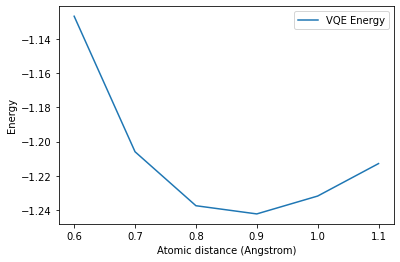

In [7]:
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
#plt.ylim([-1.5, -1.3])
plt.show()